In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.api import Holt

from sklearn.metrics import mean_squared_error, r2_score

from acquire import get_store_sales_data
from prepare import prepare_data
from evaluate import *

# Time Series Modeling Exercises

## Saas.csv

In [2]:
saas = pd.read_csv('https://ds.codeup.com/saas.csv')
saas.shape

(790458, 5)

In [3]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


### 1

Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [4]:
# Let's do a little bit of prep first.
saas.columns = [column.lower() for column in saas.columns]
saas.head(1)

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0


In [5]:
saas.month_invoiced = pd.to_datetime(saas.month_invoiced, format = '%Y-%m-%d')
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  float64       
 4   amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [6]:
saas = saas.set_index('month_invoiced').sort_index()
saas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        790458 non-null  int64  
 1   invoice_id         790458 non-null  int64  
 2   subscription_type  790458 non-null  float64
 3   amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


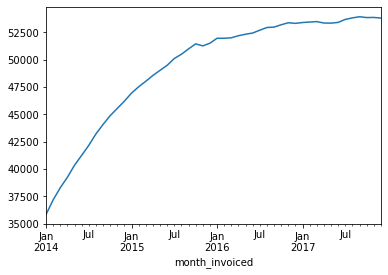

In [7]:
saas.groupby(saas.index).amount.sum().plot();

In [8]:
saas = pd.DataFrame(saas.groupby(saas.index).amount.sum())
saas.head()

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [9]:
# Now we can split the data. We'll use human based splitting.
train = saas.loc[ : '2015']
validate = saas['2016' : '2016']
test = saas['2017' : ]

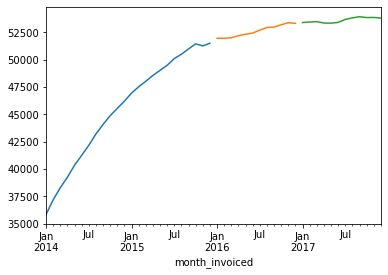

In [10]:
train.amount.plot()
validate.amount.plot()
test.amount.plot();

### 2

Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

- Simple Average

In [11]:
# Let's get the average total amount for all months
simple_avg = round(train.amount.mean(), 2)
simple_avg

45568.54

In [12]:
predictions = make_static_predictions('amount', simple_avg, validate.index)

In [13]:
predictions.head()

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [14]:
eval_df = append_eval_df('Simple Average', 'amount', validate, predictions)
eval_df

,model_type,target,rmse
0,Simple Average,amount,7063.0


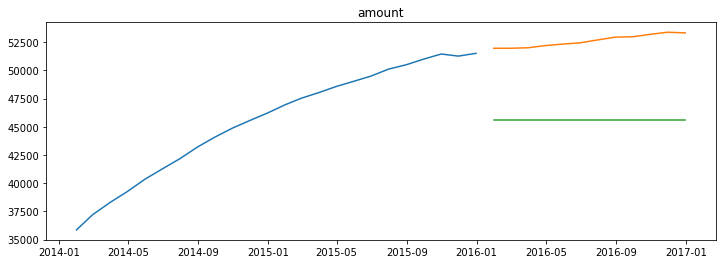

In [15]:
plot_forecast('amount', train, validate, predictions)

- Moving Average

In [16]:
# Let's do a 3 month rolling average
rolling_avg = round(train.amount.rolling(3).mean()[-1], 2)
rolling_avg

51403.33

In [17]:
predictions = make_static_predictions('amount', rolling_avg, validate.index)

In [18]:
predictions.head()

,amount
month_invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


In [19]:
eval_df = append_eval_df('Moving Average', 'amount', validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,amount,7063.0
1,Moving Average,amount,1315.0


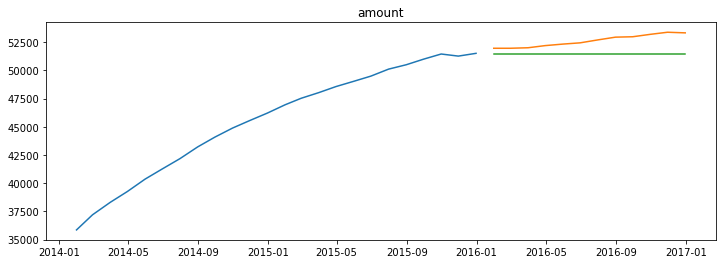

In [20]:
plot_forecast('amount', train, validate, predictions)

- Holt's Linear Trend Model

In [21]:
model = Holt(train.amount, damped_trend = True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [22]:
model = model.fit()

In [23]:
predictions = model.predict(
    start = validate.index[0],
    end = validate.index[-1]
)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [24]:
predictions = pd.DataFrame(predictions, columns = ['amount'], index = predictions.index)
predictions.head()

,amount
2016-01-31,51748.617374
2016-02-29,51961.994983
2016-03-31,52173.345509
2016-04-30,52382.688208
2016-05-31,52590.042155


In [25]:
eval_df = append_eval_df('Holt', 'amount', validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,amount,7063.0
1,Moving Average,amount,1315.0
2,Holt,amount,346.0


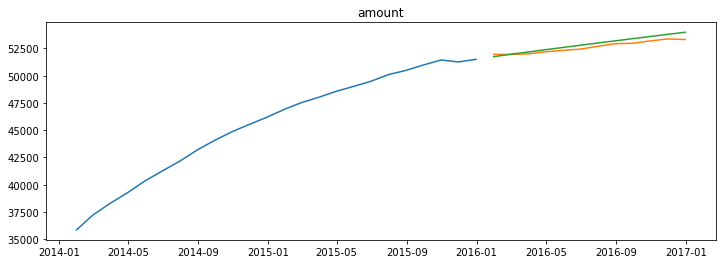

In [26]:
plot_forecast('amount', train, validate, predictions)

- Based on previous year/month/etc., this is up to you.

In [27]:
# We'll use the previous year
predictions = train.loc['2015'] + train.diff(12).mean()
predictions.head()

,amount
month_invoiced,
2015-01-31,55033.75
2015-02-28,55608.75
2015-03-31,56113.75
2015-04-30,56648.75
2015-05-31,57113.75


In [28]:
predictions.index = validate.index

In [29]:
eval_df = append_eval_df('Previous Cycle', 'amount', validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,amount,7063.0
1,Moving Average,amount,1315.0
2,Holt,amount,346.0
3,Previous Cycle,amount,5192.0


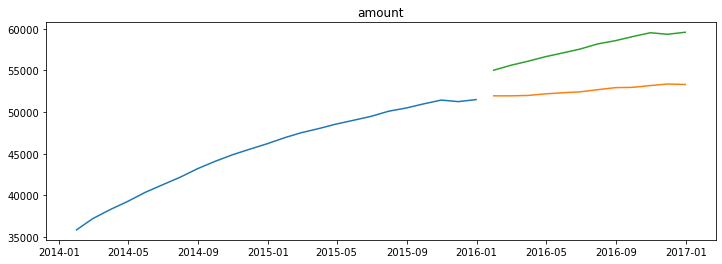

In [30]:
plot_forecast('amount', train, validate, predictions)

## Optional: Using store item demand

In [31]:
store_sales = prepare_data(get_store_sales_data())
store_sales.shape

Reading from .csv file.
Reading from .csv file.
Reading from .csv file.


(913000, 16)

In [32]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   item           913000 non-null  int64  
 1   sale_amount    913000 non-null  float64
 2   sale_id        913000 non-null  int64  
 3   store          913000 non-null  int64  
 4   item_brand     913000 non-null  object 
 5   item_name      913000 non-null  object 
 6   item_price     913000 non-null  float64
 7   item_upc12     913000 non-null  int64  
 8   item_upc14     913000 non-null  int64  
 9   store_address  913000 non-null  object 
 10  store_city     913000 non-null  object 
 11  store_state    913000 non-null  object 
 12  store_zipcode  913000 non-null  int64  
 13  month          913000 non-null  object 
 14  weekday        913000 non-null  object 
 15  sales_total    913000 non-null  float64
dtypes: float64(3), int64(6), object(7)
memory usage: 118.4+ MB

In [33]:
store_sales.store.unique()

array([ 1,  3, 10,  9,  2,  4,  6,  8,  7,  5])

In [34]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


### 1

Predict 2018 total monthly sales for a single store and/or item by creating a model with prophet.

In [46]:
# We'll predict sales for store 1
mask = store_sales.store == 1
store_1_sales = store_sales[mask]
store_1_daily_sales = pd.DataFrame(store_1_sales.resample('D').sale_amount.sum())

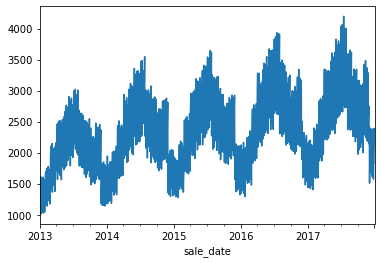

In [50]:
store_1_daily_sales.sale_amount.plot();

In [74]:
# We'll split by year
train = store_1_daily_sales.loc[ : '2015']
validate = store_1_daily_sales[store_1_daily_sales.index != '2016-02-29'].loc['2016']
test = store_1_daily_sales.loc['2017']

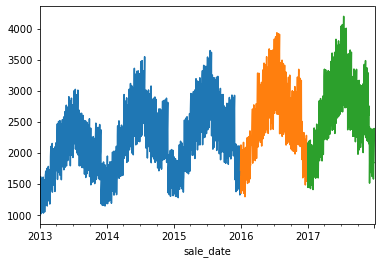

In [75]:
train.sale_amount.plot()
validate.sale_amount.plot()
test.sale_amount.plot();

In [76]:
model = Prophet()
model.fit(pd.DataFrame({
    'ds' : train.index,
    'y' : train.sale_amount
}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -29.3328
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3328.38    0.00358154        656.87     0.08441           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       3330.62   6.05332e-05        120.58   2.976e-07       0.001      202  LS failed, Hessian reset 
     194       3331.93   0.000110524       194.316   7.734e-07       0.001      313  LS failed, Hessian reset 
     199       3332.07    0.00335717       170.494           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3333.39    0.00244454        268.63           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       3333.53   3.12344e-05       71.6417   4.754e-07       0.001      523  LS failed, Hessian rese

     61.5186      0.2029      0.2029      609   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       3333.64   1.31611e-07       71.9056      0.3264      0.3264      621   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [80]:
future = model.make_future_dataframe(365)
results = model.predict(future)
predictions = results[['ds', 'yhat']].set_index('ds')
predictions.columns = ['sale_amount']
predictions.head()

,sale_amount
ds,
2013-01-01,1186.444965
2013-01-02,1196.006001
2013-01-03,1327.876399
2013-01-04,1468.131475
2013-01-05,1620.274115


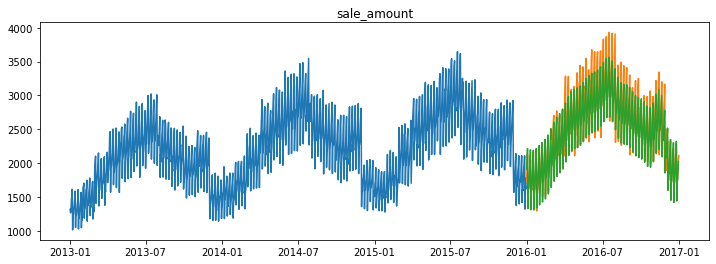

In [81]:
plot_forecast('sale_amount', train, validate, predictions.loc['2016'])

In [82]:
evaluate('sale_amount', validate, predictions.loc['2016'])

399.0

### 2

Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).

In [84]:
columns = ['yhat', 'yhat_lower', 'yhat_upper']
results.set_index('ds').resample('M').mean()[columns]

,yhat,yhat_lower,yhat_upper
ds,,,
2013-01-31,1328.171474,1196.274383,1461.790713
2013-02-28,1476.955210,1345.570566,1608.825994
2013-03-31,1799.542441,1669.627907,1934.345912
2013-04-30,2049.814618,1917.498445,2181.810199
2013-05-31,2227.721772,2095.387707,2360.676863
2013-06-30,2400.246330,2266.241139,2531.427704
2013-07-31,2493.326157,2363.418574,2625.167437
2013-08-31,2240.570477,2109.880331,2372.687815
2013-09-30,2071.920319,1938.757305,2204.123240


### 3

Plot the 2018 monthly sales predictions.

In [86]:
future = model.make_future_dataframe(730)
results = model.predict(future)
predictions = results[['ds', 'yhat']].set_index('ds')
predictions.columns = ['sale_amount']
predictions.head()

,sale_amount
ds,
2013-01-01,1186.444965
2013-01-02,1196.006001
2013-01-03,1327.876399
2013-01-04,1468.131475
2013-01-05,1620.274115


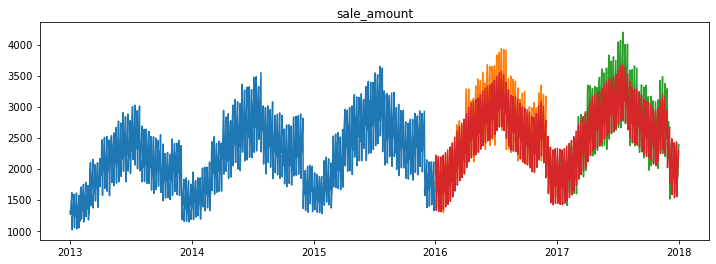

In [88]:
plot_forecast('sale_amount', train, validate, test, predictions.loc['2016' : '2017'])